### Imports

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import wordnet as wn
import math
from collections import Counter
from sklearn.model_selection import GridSearchCV
import re
import string
from joblib import dump, load
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from nltk import bigrams, trigrams


### Global Varaibles

In [24]:
# global varibles
SAVE = True
# Load data
#gpt_data = pd.read_csv("data_process/xl-1542M.csv")
human_data = pd.read_csv("data_process/human.csv")
gpt_data = pd.read_csv("data_process/large-762m.csv")

# Sample
n = 100

# Take a random sample of instances from each dataset
gpt_data = gpt_data.sample(n, random_state=1)
human_data = human_data.sample(n, random_state=1)

# Combine the two datasets into one
data = pd.concat([gpt_data, human_data], ignore_index=True)
#data = pd.read_csv("/kaggle/input/nlpdata2-gpt2/processed_sample_data.csv")
data = data.sample(frac=1)
#data = data.sample(10000, random_state = 42)


### Feature extraction functions

In [25]:
# Feature extraction functions
def sentence_length(text):
    text = str(text)
    sentences = nltk.sent_tokenize(text)
    numberofsentences = len(sentences)
    total_words = 0
    for i in sentences:
        total_words += len(i.split())
    avg_sentence = total_words / numberofsentences
    return numberofsentences, avg_sentence

def repetitivewords(text):
    text = str(text)
    token = nltk.word_tokenize(text.lower())
    synsets = []
    for i in token:
        synsets.extend(wn.synsets(i))
    synonyms = []
    for synset in synsets:
        synonyms.append([lemma.name() for lemma in synset.lemmas()])
    repeat = 0
    for index in range(len(synonyms)):
        for nextindex in range(index+1, len(synonyms)):
            if len(set(synonyms[index]) & set(synonyms[nextindex])) > 0:
                repeat += 1
    return repeat / len(token)

def entropy(text):
    text = str(text)
    tokens = nltk.word_tokenize(text.lower())
    tokennumber = Counter(tokens)
    total = len(tokens)
    numberofprobs = []
    for count in tokennumber.values():
        prob = count / total
        numberofprobs.append(prob)
    entropy = 0.0
    for i in numberofprobs:
        if i > 0:
            entropy -= i * (math.log(i, 2))
    return entropy

def count_punctuation(text):
     text = str(text)
     sentences = nltk.sent_tokenize(text)
     numberofsentences = len(sentences)
     count = 0
     for char in text:
          if char in string.punctuation:
              count += 1
     return count / numberofsentences if numberofsentences > 0 else 0

def count_numbers(text):
    count = len(list(filter(lambda w: any([c.isdigit() for c in w]), text.split())))
    num_sentences = len(nltk.sent_tokenize(text))
    return count / num_sentences if num_sentences > 0 else 0



### Training

In [26]:
# Extract features
data['sent_length'], data['avg_sent_length'] = zip(*data['text'].apply(sentence_length))
data['repetitive_words'] = data['text'].apply(repetitivewords)
data['text_entropy'] = data['text'].apply(entropy)
# Compute the new features
data['punctuation_count'] = data['text'].apply(count_punctuation)
data['number_count'] = data['text'].apply(count_numbers)

In [27]:
# Split data into training and testing sets
X = data.drop(columns=['generated'])
X = X.drop(columns=['sent_length'])
y = data['generated']

# Split data into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

# Fill NaN values with an empty string
X_train['text'] = X_train['text'].fillna('')
X_val['text'] = X_val['text'].fillna('')
X_test['text'] = X_test['text'].fillna('')

# Extract TF-IDF features
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train['text'])
X_val_tfidf = tfidf.transform(X_val['text'])
X_test_tfidf = tfidf.transform(X_test['text'])

# Store the extracted TF-IDF features
X_train['tfidf'] = list(X_train_tfidf.toarray())
X_val['tfidf'] = list(X_val_tfidf.toarray())
X_test['tfidf'] = list(X_test_tfidf.toarray())


# Combine TF-IDF features with the extracted features
X_train_features = X_train.drop(columns=['text']).to_numpy()
X_val_features = X_val.drop(columns=['text']).to_numpy()
X_test_features = X_test.drop(columns=['text']).to_numpy()

# Scale the extracted features
#Wscaler = StandardScaler()
#X_train_features_scaled = scaler.fit_transform(X_train_features)
#X_val_features_scaled = scaler.transform(X_val_features)
#X_test_features_scaled = scaler.transform(X_test_features)

# Combine TF-IDF features with the scaled extracted features
# Prepare the feature matrix
X_train_combined = np.column_stack((X_train['avg_sent_length'].values,
                                    X_train['repetitive_words'].values,
                                    X_train['text_entropy'].values,
                                    X_train['punctuation_count'].values,
                                    X_train['number_count'].values,
                                    X_train_tfidf.toarray()))

X_val_combined = np.column_stack((X_val['avg_sent_length'].values,
                                  X_val['repetitive_words'].values,
                                  X_val['text_entropy'].values,
                                  X_val['punctuation_count'].values,
                                  X_val['number_count'].values,
                                  X_val_tfidf.toarray()))

X_test_combined = np.column_stack((X_test['avg_sent_length'].values,
                                   X_test['repetitive_words'].values,
                                   X_test['text_entropy'].values,
                                   X_test['punctuation_count'].values,
                                   X_test['number_count'].values,
                                   X_test_tfidf.toarray()))


# Perform Grid Search for optimal parameters
rf_params = {'n_estimators': [50, 100],
             'max_depth': [None, 30]}
lr_params = {'C': [0.1, 1, 10],
             'solver': ['newton-cg', 'liblinear']}
svm_params = {'C': [1, 10],
              'kernel': ['linear', 'rbf']}


model_rf = RandomForestClassifier(random_state=42)
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_svm = SVC(random_state=42)

grid_rf = GridSearchCV(model_rf, rf_params, cv=5)
grid_rf.fit(X_val_combined, y_val)
best_rf_params = grid_rf.best_params_

grid_lr = GridSearchCV(model_lr, lr_params, cv=5)
grid_lr.fit(X_val_combined, y_val)
best_lr_params = grid_lr.best_params_

grid_svm = GridSearchCV(model_svm, svm_params, cv=5)
grid_svm.fit(X_val_combined, y_val)
best_svm_params = grid_svm.best_params_

# Train models with optimal parameters
model_rf = RandomForestClassifier(**best_rf_params, random_state=42)
model_rf.fit(X_train_combined, y_train)

model_lr = LogisticRegression(**best_lr_params, random_state=42, max_iter=1000)
model_lr.fit(X_train_combined, y_train)

model_svm = SVC(**best_svm_params, random_state=42)
model_svm.fit(X_train_combined, y_train)

if SAVE:
    dump(model_rf, 'model_rf.joblib')
    dump(model_lr, 'model_lr.joblib')
    dump(model_svm, 'model_svm.joblib')
    dump(tfidf, 'tfidf_transformer.joblib')

# Model evaluation
models = {'Random Forest': model_rf,
          'Logistic Regression': model_lr,
          'SVM': model_svm}
for name, model in models.items():
    y_pred_train = model.predict(X_train_combined)  # Predict the labels for the training data
    train_report = classification_report(y_train, y_pred_train, output_dict=True)

    train_precision = train_report['macro avg']['precision']
    train_recall = train_report['macro avg']['recall']
    train_f_measure = train_report['macro avg']['f1-score']
    train_accuracy = train_report['accuracy']

    print("{} Train Evaluation:".format(name))
    print("  Precision: {:.5f}".format(train_precision))
    print("  Recall: {:.5f}".format(train_recall))
    print("  F-measure: {:.5f}".format(train_f_measure))
    print("  Accuracy: {:.5f}\n".format(train_accuracy))

    y_pred_test = model.predict(X_test_combined)  # Predict the labels for the testing data
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    test_precision = test_report['macro avg']['precision']
    test_recall = test_report['macro avg']['recall']
    test_f_measure = test_report['macro avg']['f1-score']
    test_accuracy = test_report['accuracy']

    print("{} Test Evaluation:".format(name))
    print("  Precision: {:.5f}".format(test_precision))
    print("  Recall: {:.5f}".format(test_recall))
    print("  F-measure: {:.5f}".format(test_f_measure))
    print("  Accuracy: {:.5f}\n".format(test_accuracy))



Random Forest Train Evaluation:
  Precision: 1.00000
  Recall: 1.00000
  F-measure: 1.00000
  Accuracy: 1.00000

Random Forest Test Evaluation:
  Precision: 0.54306
  Recall: 0.54167
  F-measure: 0.54172
  Accuracy: 0.56667

Logistic Regression Train Evaluation:
  Precision: 0.69295
  Recall: 0.68791
  F-measure: 0.68748
  Accuracy: 0.69065

Logistic Regression Test Evaluation:
  Precision: 0.45238
  Recall: 0.45833
  F-measure: 0.45055
  Accuracy: 0.50000

SVM Train Evaluation:
  Precision: 0.61633
  Recall: 0.60634
  F-measure: 0.60057
  Accuracy: 0.61151

SVM Test Evaluation:
  Precision: 0.37302
  Recall: 0.38889
  F-measure: 0.37729
  Accuracy: 0.43333



### Evaluation

In [28]:


for name, model in models.items():
    y_pred_test = model.predict(X_test_combined)  # Predict the labels for the testing data

    cm_test = confusion_matrix(y_test, y_pred_test)

    # Test evaluation
    TP_test, FP_test, TN_test, FN_test = cm_test[1, 1], cm_test[0, 1], cm_test[0, 0], cm_test[1, 0]
    precision_positive_test = TP_test / (TP_test + FP_test)
    recall_positive_test = TP_test / (TP_test + FN_test)
    precision_negative_test = TN_test / (TN_test + FN_test)
    recall_negative_test = TN_test / (TN_test + FP_test)

    f_measure_positive_test = 2 * (precision_positive_test * recall_positive_test) / (precision_positive_test + recall_positive_test)
    f_measure_negative_test = 2 * (precision_negative_test * recall_negative_test) / (precision_negative_test + recall_negative_test)

    print("{} Test Evaluation:".format(name))
    print("  Positive Class:")
    print("    Precision: {:.3f}".format(precision_positive_test))
    print("    Recall: {:.3f}".format(recall_positive_test))
    print("    F-measure: {:.3f}".format(f_measure_positive_test))
    print("  Negative Class:")
    print("    Precision: {:.3f}".format(precision_negative_test))
    print("    Recall: {:.3f}".format(recall_negative_test))
    print("    F-measure: {:.3f}\n".format(f_measure_negative_test))

Random Forest Test Evaluation:
  Positive Class:
    Precision: 0.455
    Recall: 0.417
    F-measure: 0.435
  Negative Class:
    Precision: 0.632
    Recall: 0.667
    F-measure: 0.649

Logistic Regression Test Evaluation:
  Positive Class:
    Precision: 0.333
    Recall: 0.250
    F-measure: 0.286
  Negative Class:
    Precision: 0.571
    Recall: 0.667
    F-measure: 0.615

SVM Test Evaluation:
  Positive Class:
    Precision: 0.222
    Recall: 0.167
    F-measure: 0.190
  Negative Class:
    Precision: 0.524
    Recall: 0.611
    F-measure: 0.564



In [29]:
def predict_string(s, model, tfidf_transformer):
    # Extract features
    _, avg_sent_length = sentence_length(s)  # We only need the average sentence length
    repetitive_words = repetitivewords(s)
    text_entropy = entropy(s)
    punctuation_count = count_punctuation(s)
    number_count = count_numbers(s)

    # Transform the input string into a TF-IDF vector
    s_tfidf = tfidf_transformer.transform([s])

    # Combine the TF-IDF vector with the extracted features
    s_features = np.array([avg_sent_length, repetitive_words, text_entropy, punctuation_count, number_count]).reshape(1, -1)
    s_combined = np.hstack((s_tfidf.toarray(), s_features))

    # Make a prediction using the model
    prediction = model.predict(s_combined)

    return prediction

# Test the function with a sample string and the SVM model
s = """
L’Ami Jean is a Basque-inspired restaurant located in the 7th arrondissement. Chef Stéphane Joly is known for his bold and flavorful dishes that are inspired by the Basque region of France. The restaurant offers a warm and friendly atmosphere that is perfect for dining with the author of “Let’s Eat France.” You can expect a menu that is full of delicious, seasonal dishes made with fresh, local ingredients.
"""
tfidf_transformer = load('tfidf_transformer.joblib')
#tfidf = TfidfVectorizer()
prediction = predict_string(s, model_svm, tfidf_transformer)
prediction1 = predict_string(s, model_rf, tfidf_transformer)
prediction2 = predict_string(s, model_lr, tfidf_transformer)
print("SVM Prediction:", prediction)
print("Random Forest Prediction:", prediction1)
print("Logistic Regression Prediction:", prediction2)




SVM Prediction: [0]
Random Forest Prediction: [1]
Logistic Regression Prediction: [1]


## Fake data test

### Error Analysis

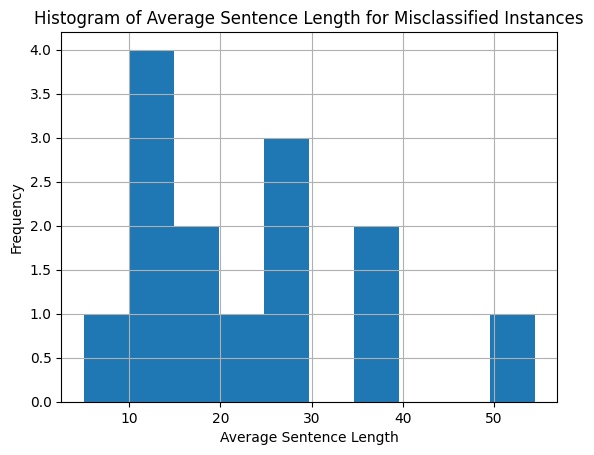

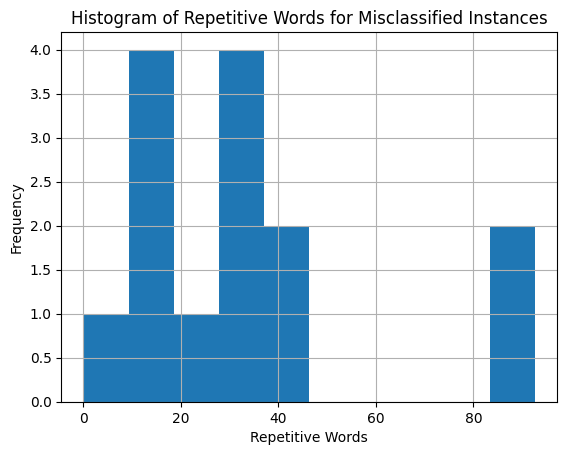

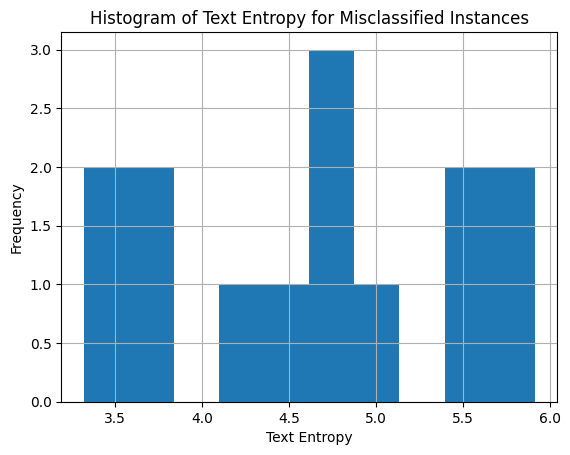

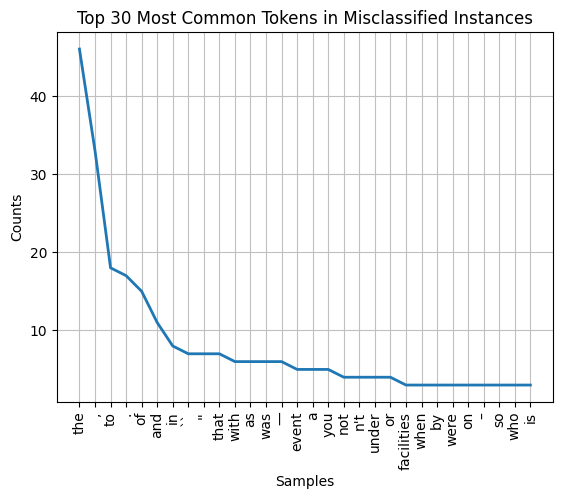

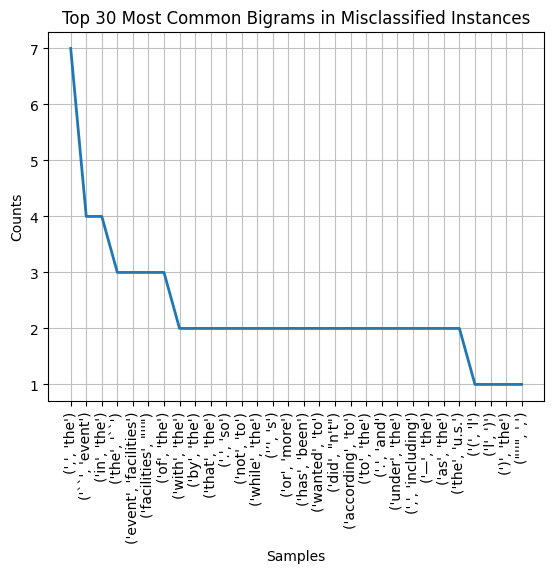

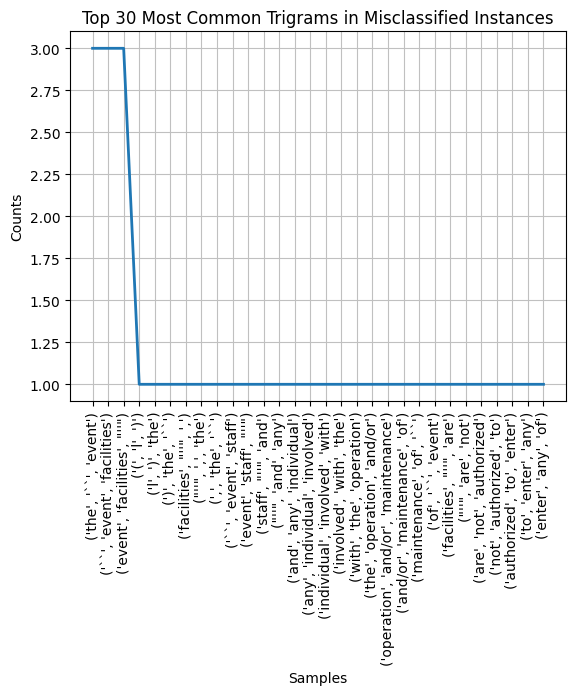

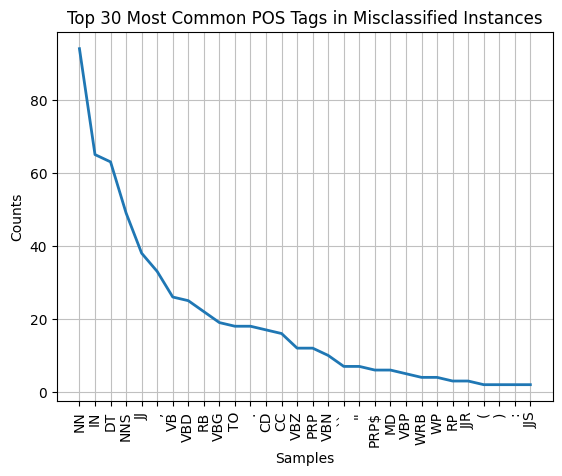

In [30]:
# Predict the labels for the validation data
best_model = model_svm  # Use the best performing model from your previous analysis
y_pred_val = best_model.predict(X_val_combined)

# Find the misclassified instances
misclassified_indices = np.where(y_val != y_pred_val)[0]
misclassified_data = X_val.iloc[misclassified_indices]

# Analyze the misclassified instances
#misclassified_data['sent_length'].hist()
#plt.xlabel('Sentence Length')
#plt.ylabel('Frequency')
#plt.title('Histogram of Sentence Length for Misclassified Instances')
#plt.show()

misclassified_data['avg_sent_length'].hist()
plt.xlabel('Average Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Average Sentence Length for Misclassified Instances')
#plt.savefig('avg_sent_length.png')
plt.show()

misclassified_data['repetitive_words'].hist()
plt.xlabel('Repetitive Words')
plt.ylabel('Frequency')
plt.title('Histogram of Repetitive Words for Misclassified Instances')
#plt.savefig('repet_words.png')
plt.show()

misclassified_data['text_entropy'].hist()
plt.xlabel('Text Entropy')
plt.ylabel('Frequency')
plt.title('Histogram of Text Entropy for Misclassified Instances')
#plt.savefig('entropy.png')
plt.show()

# Concatenate misclassified texts
misclassified_texts = ' '.join(misclassified_data['text'])

# Tokenize the misclassified texts
tokens = nltk.word_tokenize(misclassified_texts.lower())

# Generate a frequency distribution of the tokens
fdist = FreqDist(tokens)

# Visualize the frequency distribution
fdist.plot(30, cumulative=False, title='Top 30 Most Common Tokens in Misclassified Instances')
#plt.savefig('most_common.png')
plt.show()

# Create bigrams and trigrams
bigram_tokens = list(bigrams(tokens))
trigram_tokens = list(trigrams(tokens))

# Generate frequency distributions for bigrams and trigrams
fdist_bigrams = FreqDist(bigram_tokens)
fdist_trigrams = FreqDist(trigram_tokens)

# Visualize the frequency distributions
fdist_bigrams.plot(30, cumulative=False, title='Top 30 Most Common Bigrams in Misclassified Instances')
#plt.savefig('bigrams.png')
plt.show()

fdist_trigrams.plot(30, cumulative=False, title='Top 30 Most Common Trigrams in Misclassified Instances')
#plt.savefig('trigrams.png')
plt.show()

# Perform POS tagging on tokens
pos_tags = nltk.pos_tag(tokens)

# Count the frequency of each POS tag
pos_freq = nltk.FreqDist(tag for (word, tag) in pos_tags)

# Visualize the frequency distribution of POS tags
pos_freq.plot(30, cumulative=False, title='Top 30 Most Common POS Tags in Misclassified Instances')
#plt.savefig('pos_tag.png')
plt.show()


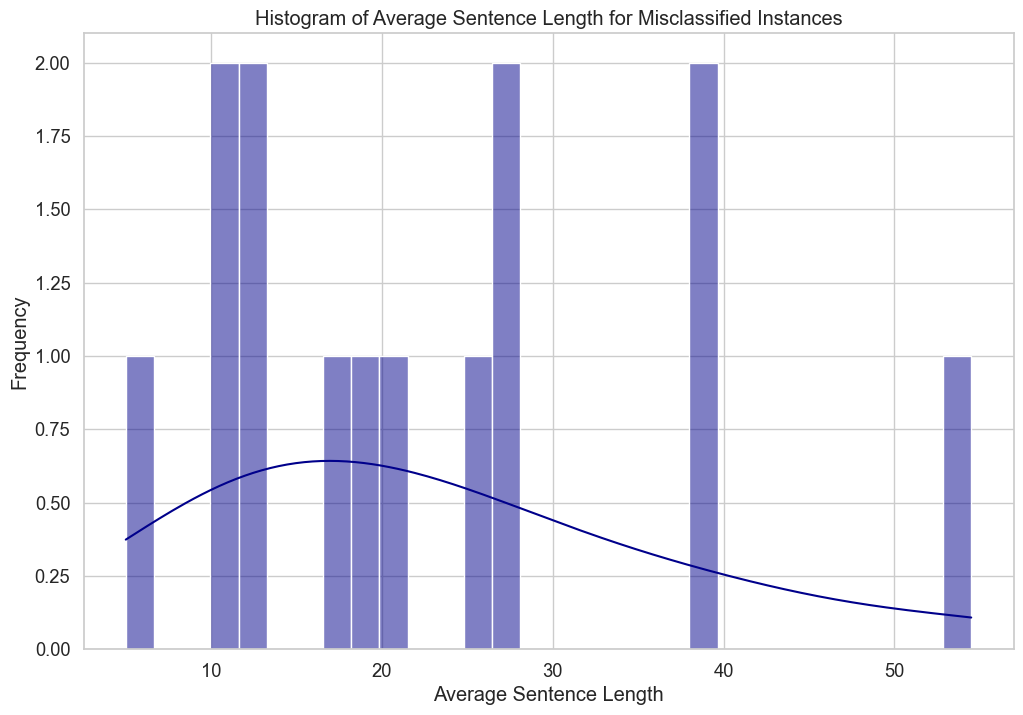

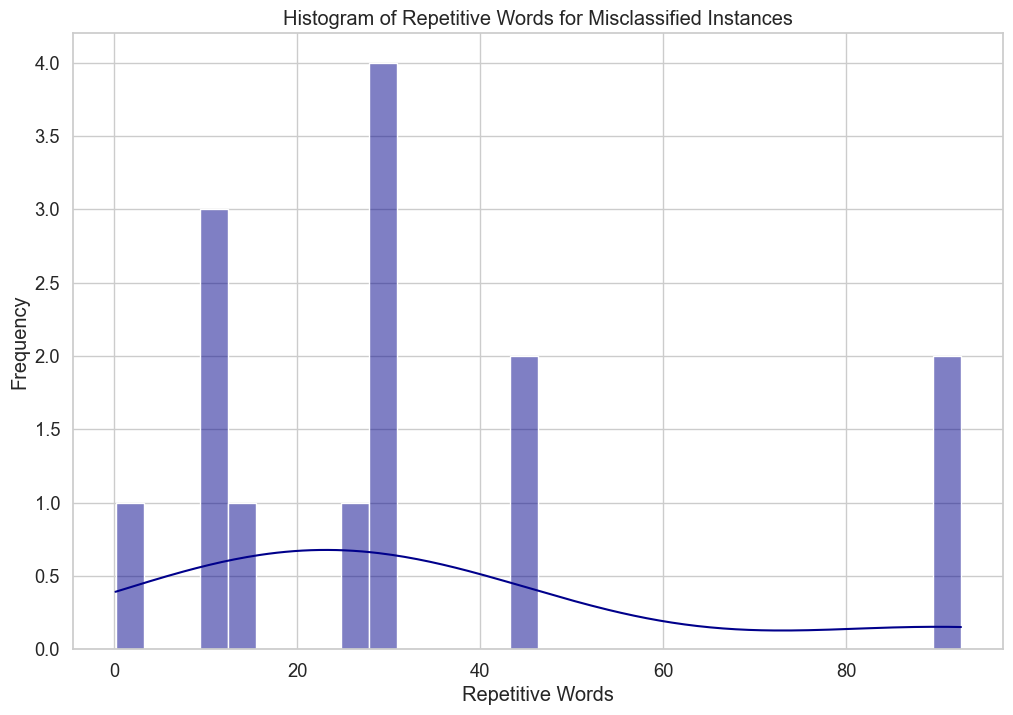

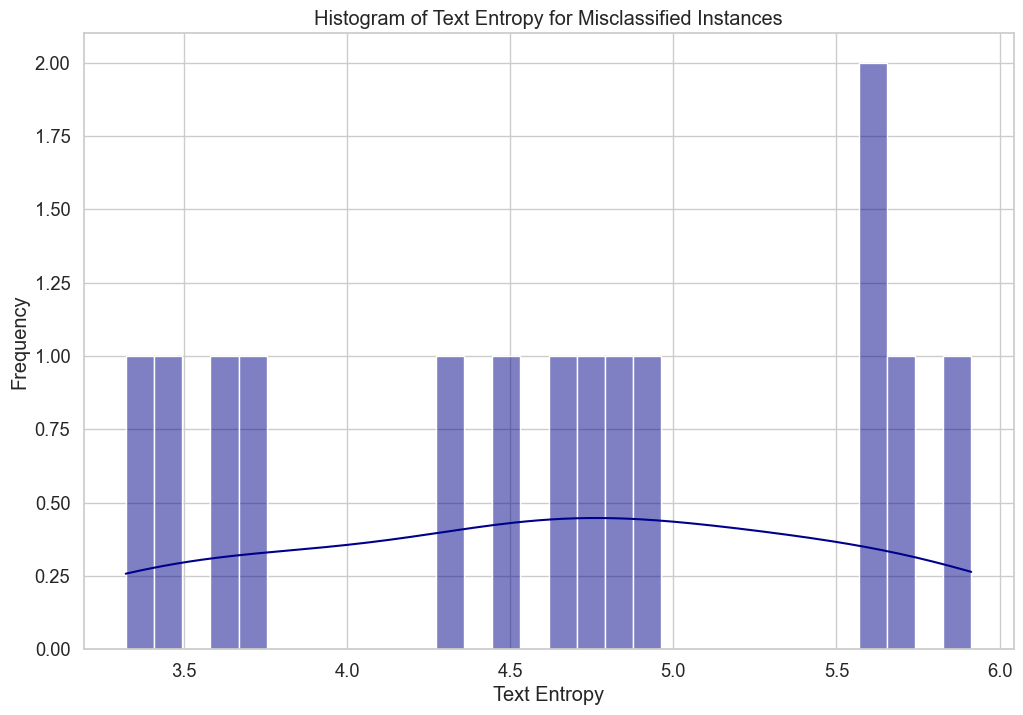

In [31]:
# Set the style for the plot
sns.set(style='whitegrid', font_scale=1.2)

def plot_histogram(data, xlabel, ylabel, title, filename):
    plt.figure(figsize=(12, 8))
    sns.histplot(data, kde=True, color='darkblue', bins=30)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(filename)
    plt.show()

plot_histogram(misclassified_data['avg_sent_length'], 'Average Sentence Length', 'Frequency', 'Histogram of Average Sentence Length for Misclassified Instances', 'avg_sent_length.png')

plot_histogram(misclassified_data['repetitive_words'], 'Repetitive Words', 'Frequency', 'Histogram of Repetitive Words for Misclassified Instances', 'repet_words.png')

plot_histogram(misclassified_data['text_entropy'], 'Text Entropy', 'Frequency', 'Histogram of Text Entropy for Misclassified Instances', 'entropy.png')

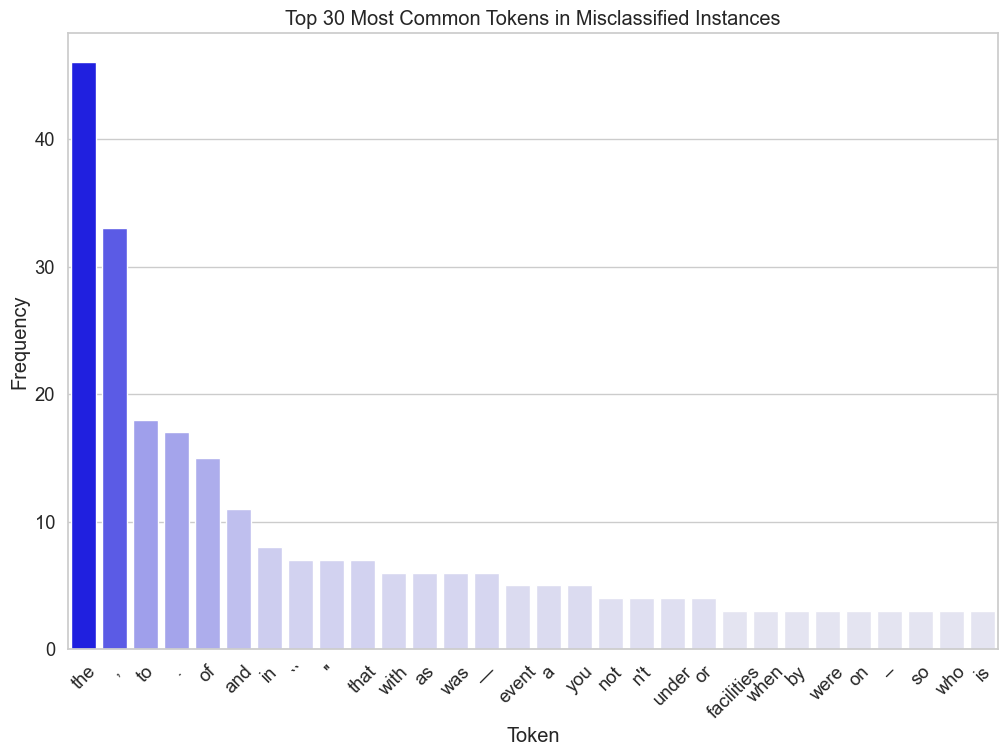

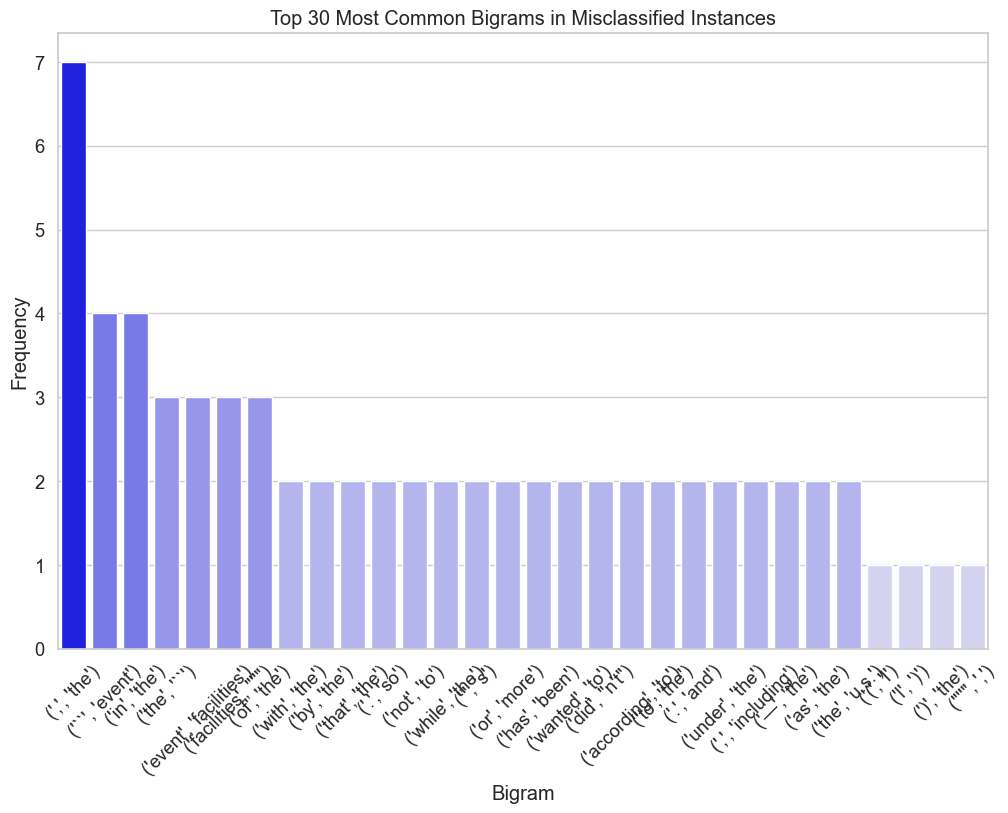

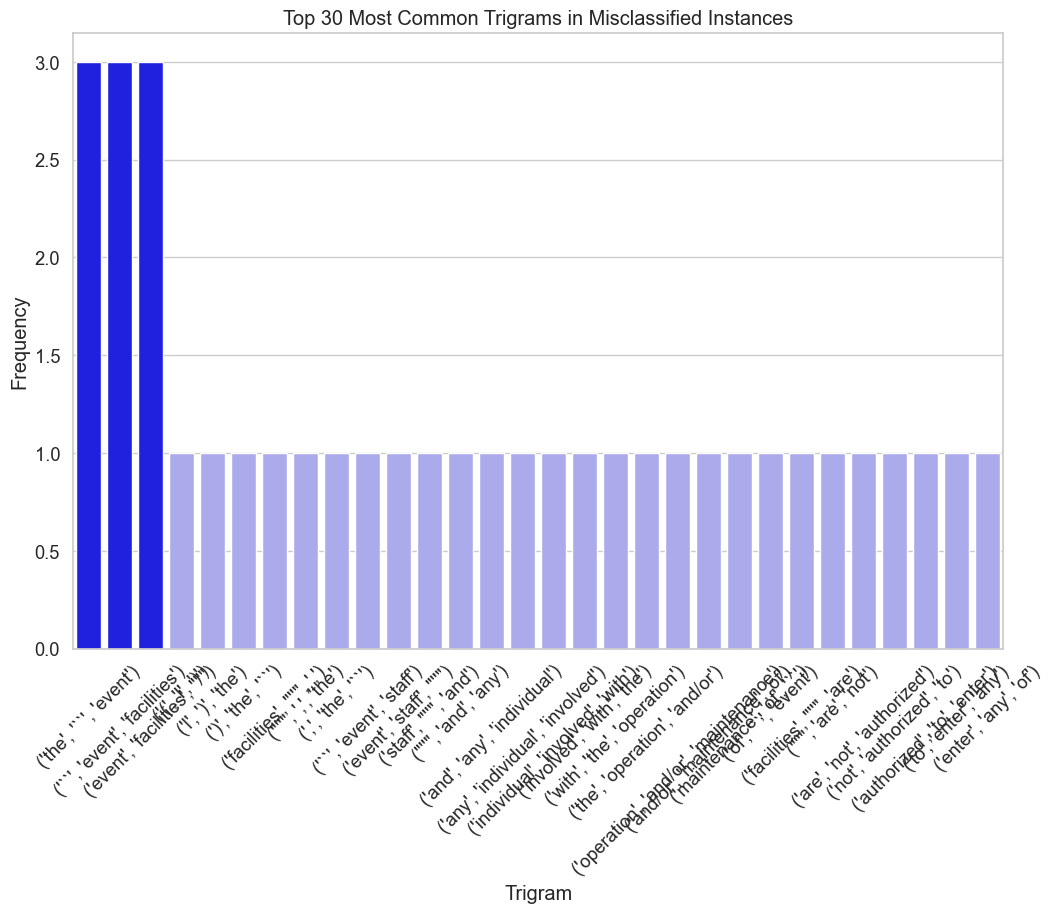

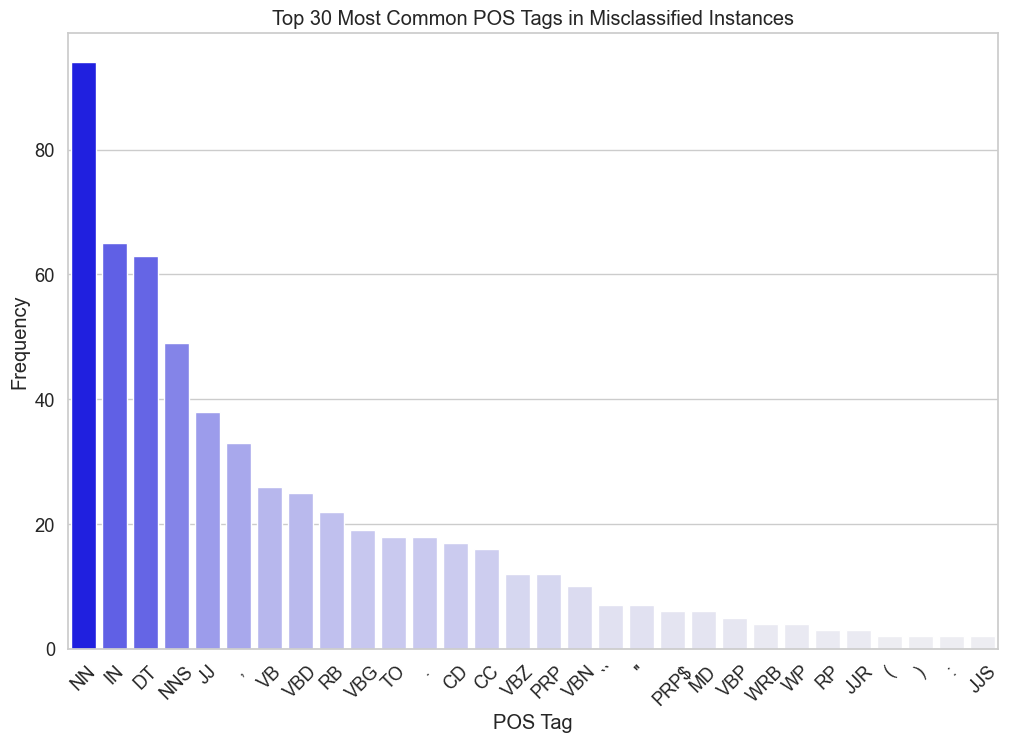

In [32]:
# Create a colormap
cmap = sns.light_palette("blue", as_cmap=True)

# Top 30 most common tokens
plt.figure(figsize=(12, 8))
most_common = pd.DataFrame(fdist.most_common(30), columns=['Token', 'Frequency'])
sns.barplot(x='Token', y='Frequency', data=most_common, palette=cmap(most_common['Frequency'] / most_common['Frequency'].max()))
plt.title('Top 30 Most Common Tokens in Misclassified Instances')
plt.xticks(rotation=45)
plt.savefig('most_common.png', bbox_inches='tight')
plt.show()

# Top 30 most common bigrams
plt.figure(figsize=(12, 8))
most_common_bigrams = pd.DataFrame(fdist_bigrams.most_common(30), columns=['Bigram', 'Frequency'])
sns.barplot(x='Bigram', y='Frequency', data=most_common_bigrams, palette=cmap(most_common_bigrams['Frequency'] / most_common_bigrams['Frequency'].max()))
plt.title('Top 30 Most Common Bigrams in Misclassified Instances')
plt.xticks(rotation=45)
plt.savefig('bigrams.png', bbox_inches='tight')
plt.show()

# Top 30 most common trigrams
plt.figure(figsize=(12, 8))
most_common_trigrams = pd.DataFrame(fdist_trigrams.most_common(30), columns=['Trigram', 'Frequency'])
sns.barplot(x='Trigram', y='Frequency', data=most_common_trigrams, palette=cmap(most_common_trigrams['Frequency'] / most_common_trigrams['Frequency'].max()))
plt.title('Top 30 Most Common Trigrams in Misclassified Instances')
plt.xticks(rotation=45)
plt.savefig('trigrams.png', bbox_inches='tight')
plt.show()

# Top 30 most common POS tags
plt.figure(figsize=(12, 8))
most_common_pos_tags = pd.DataFrame(pos_freq.most_common(30), columns=['POS Tag', 'Frequency'])
sns.barplot(x='POS Tag', y='Frequency', data=most_common_pos_tags, palette=cmap(most_common_pos_tags['Frequency'] / most_common_pos_tags['Frequency'].max()))
plt.title('Top 30 Most Common POS Tags in Misclassified Instances')
plt.xticks(rotation=45)
plt.savefig('pos_tag.png', bbox_inches='tight')
plt.show()